In [1]:
from torchdyn.core import NeuralODE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl

In [2]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)
torch.set_float32_matmul_precision("high")

In [3]:
def plot_l63(data, n, style="scatter"):
    if n > 0:
        data = data[:n, :]
    else:
        n = data.shape[0]
    x, y, z = data.T
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    if style == "scatter":
        ax.scatter(x, y, z, s=1)
    elif style == "line":
        ax.plot(x, y, z, lw=0.3)
    else:
        raise ValueError
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"L63, {n} points")
    plt.show()

In [4]:
def get_loader(
    train_file: str,
    test_file: str,
    plot: bool = False,
    name: str = "",
    n_points: int = 1000,
    lag=1,
):
    traintensor = np.load(train_file)
    test = np.load(test_file)
    print(f"raw data shapes -- train: {traintensor.shape}, test: {test.shape}")
    X = torch.Tensor(traintensor[:-lag, :])
    Y = torch.Tensor(traintensor[lag:, :])
    print(f"train shapes -- x: {X.shape}, y: {Y.shape}")
    if plot and name == "l63":
        plot_l63(traintensor, n=n_points)
        plot_l63(traintensor, n=n_points, style="line")
    traintensor = data.TensorDataset(X, Y)
    trainloader = data.DataLoader(
        traintensor, batch_size=len(X), shuffle=True, num_workers=0
    )
    return trainloader

In [5]:
def get_loader_l63(plot=False, n_points=1000):
    return get_loader(
        train_file="lorenz63_on0.05_train.npy",
        test_file="lorenz63_test.npy",
        plot=plot,
        n_points=n_points,
        name="l63",
    )

In [6]:
def get_loader_l96():
    return get_loader(
        train_file="lorenz96_on0.05_train.npy",
        test_file="lorenz96_test.npy",
    )

In [7]:
class Learner_l63(pl.LightningModule):
    def __init__(self, t_span: torch.Tensor, model: nn.Module, lr: float):
        super().__init__()
        self.model, self.t_span = model, t_span
        self.trainloader = get_loader_l63()
        self.starting_lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1]  # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        print(f"loss: {loss}, lr: {self.optimizers().param_groups[0]['lr']}")
        self.log("loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.starting_lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "loss"}

    def train_dataloader(self):
        return self.trainloader

In [8]:
def get_model_l63():
    layers = [
        nn.Linear(3, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 3),
    ]
    f = nn.Sequential(*layers)
    model = NeuralODE(f, sensitivity="adjoint", solver="dopri5")
    # dopri5 works well for some reason
    # tsitouras45 is default but it sucks
    return model

In [9]:
model = Learner_l63(model=get_model_l63(), t_span=torch.linspace(0, 1, 2), lr=1e-2)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices="auto")
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/anuramat/.local/share/ghq/github.com/anuramat/uhd-mldyn/final/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
raw data shapes -- train: (100000, 3), test: (100000, 3)
train shapes -- x: torch.Size([99999, 3]), y: torch.Size([99999, 3])



  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 66.9 K | train
--------------------------------------------
66.9 K    Trainable params
0         Non-trainable params
66.9 K    Total params
0.268     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
/home/anuramat/.local/share/ghq/github.com/anuramat/uhd-mldyn/final/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/anuramat/.local/share/ghq/github.com/anuramat/uhd-mldyn/final/venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ev

Training: |                                                                                                   …

loss: 0.01180292943283286, lr: 0.01
loss: 0.027843231485161136, lr: 0.01
loss: 0.010687721531645579, lr: 0.01
loss: 0.01020972088464982, lr: 0.01
loss: 0.009715496528865579, lr: 0.01
loss: 0.009073651179209292, lr: 0.01
loss: 0.00824692943021974, lr: 0.01
loss: 0.007363762516529157, lr: 0.01
loss: 0.007054780906497158, lr: 0.01
loss: 0.0070520234147918495, lr: 0.01
loss: 0.007462387725021719, lr: 0.01
loss: 0.00652090850768158, lr: 0.01
loss: 0.006127551754429408, lr: 0.01
loss: 0.0065149886756133545, lr: 0.01
loss: 0.006271153682354652, lr: 0.01
loss: 0.005812923479784337, lr: 0.01
loss: 0.005894823624004935, lr: 0.01
loss: 0.005943622259149734, lr: 0.01
loss: 0.005652246192174327, lr: 0.01
loss: 0.005559383380711273, lr: 0.01
loss: 0.0056347275406027865, lr: 0.01
loss: 0.005533241975396888, lr: 0.01
loss: 0.0053894648051023356, lr: 0.01
loss: 0.005416889074326382, lr: 0.01
loss: 0.005409921692913874, lr: 0.01
loss: 0.005341990479122082, lr: 0.01
loss: 0.005322885079094639, lr: 0.01
l

`Trainer.fit` stopped: `max_epochs=50` reached.


In [23]:
def make_trajectory(model, start, time, n):
    x = torch.Tensor(start)
    with torch.no_grad():
        _, traj = model.model(x, torch.linspace(0, time-1, time*n))
        return traj.numpy()

raw data shapes -- train: (100000, 3), test: (100000, 3)
train shapes -- x: torch.Size([99999, 3]), y: torch.Size([99999, 3])


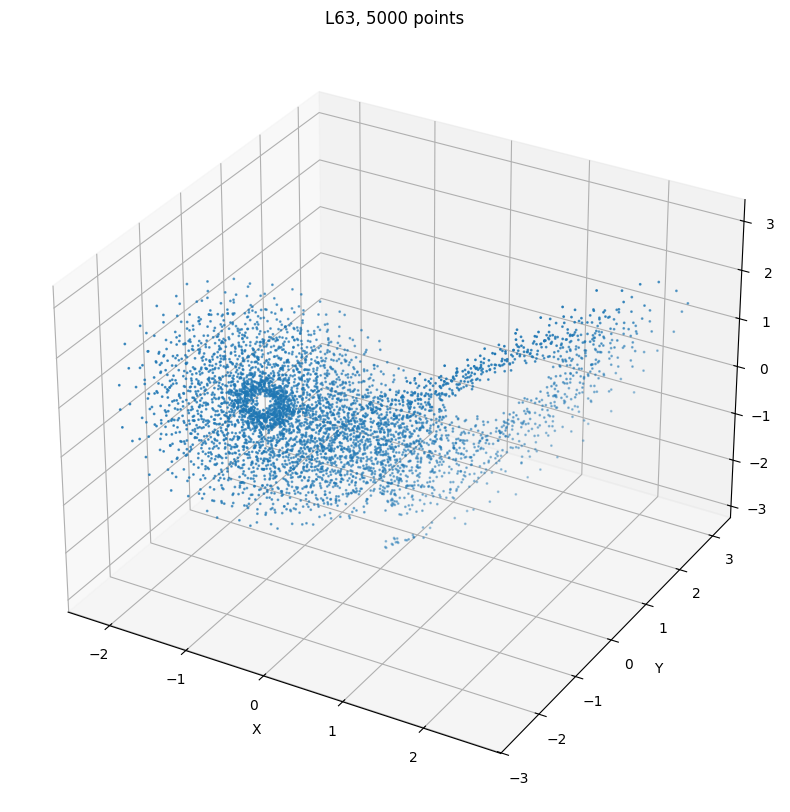

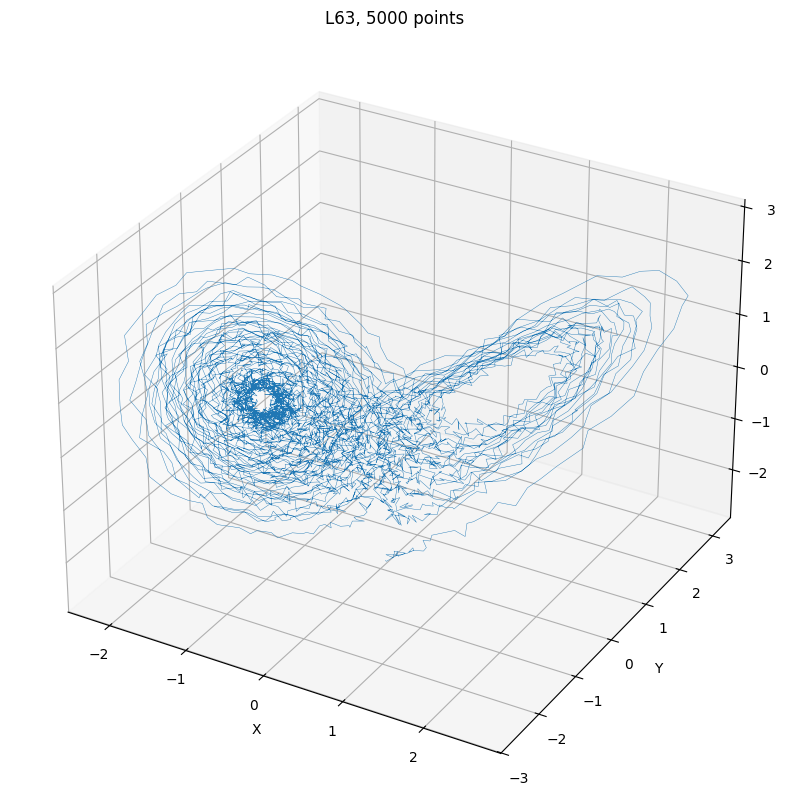

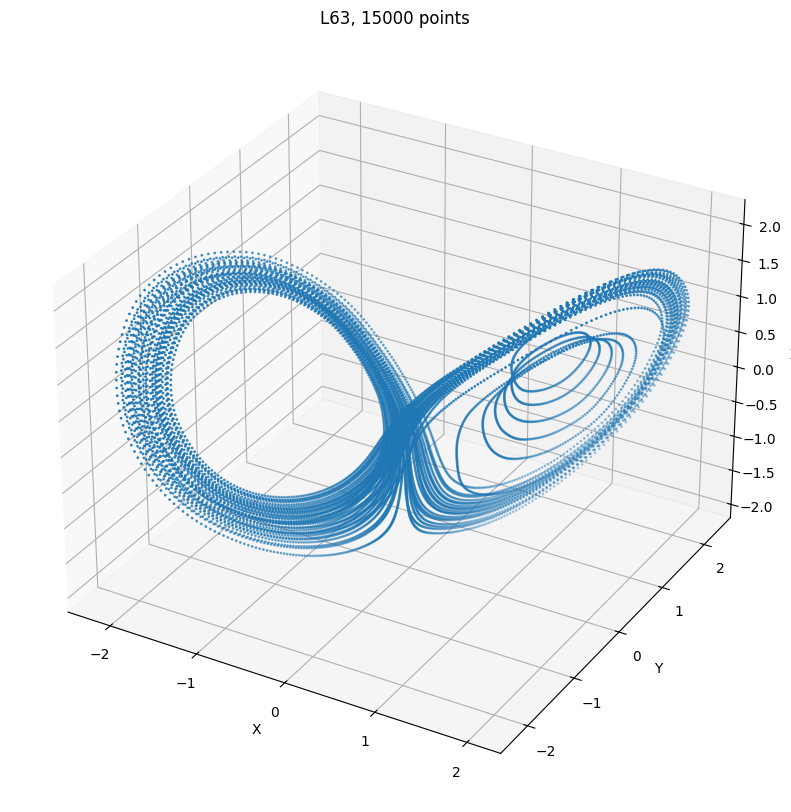

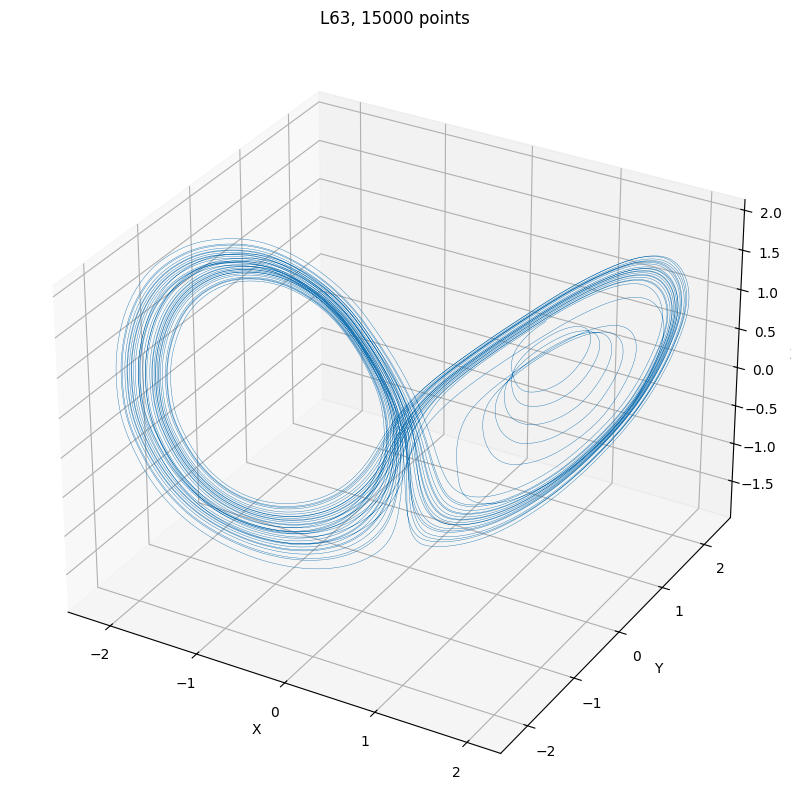

In [22]:
n_points = 5000
preds = make_trajectory(model, [1, 1, 1], time=n_points, n=3)
get_loader_l63(True, n_points=n_points)
plot_l63(preds, -1, "scatter")
plot_l63(preds, -1, "line")